In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
import gzip
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.optim as optim

import time

np.random.seed(2021)

## Loading the train and test data

In [2]:
train_df = pd.read_csv('../input/mnist-fashion/train_data.csv')
test_df = pd.read_csv('../input/mnist-fashion/test_data.csv')
y_train = train_df['Label'].values
x_train = train_df.drop('Label', axis=1)
y_test = test_df['Label'].values
x_test = test_df.drop('Label', axis=1)
x_train = np.reshape(x_train.values, (len(x_train), 28, 28))
x_test = np.reshape(x_test.values, (len(x_test), 28, 28))
print('Number of Train Images: '+str(len(x_train)))
print('Number of Test Images: '+str(len(x_test)))
print('Number of Classes in Trian_images: ' + str(len(np.unique(y_train))))
print('Number of Classes in Test_images: ' + str(len(np.unique(y_test))))


Number of Train Images: 60000
Number of Test Images: 10000
Number of Classes in Trian_images: 10
Number of Classes in Test_images: 10


## Class Distribution in train and test images

In [3]:
class_name = {0 : 'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',5:'Sandal', 6:'Shirt', 
             7: 'Sneaker', 8: 'Bag', 9:'Ankle Boot'}
train_class, train_counts = np.unique(y_train, return_counts=True)
test_class, test_counts = np.unique(y_test, return_counts=True)
classes = list(class_name.values())
fig = go.Figure(data=[
    go.Bar(name='Train', x=classes, y=train_counts, text=train_counts),
    go.Bar(name='Test', x=classes, y=test_counts, text=test_counts)
])
# Change the bar mode
fig.update_layout(barmode='group',xaxis_title="Class",
                    yaxis_title="Numbe rof Images",)
fig.show()

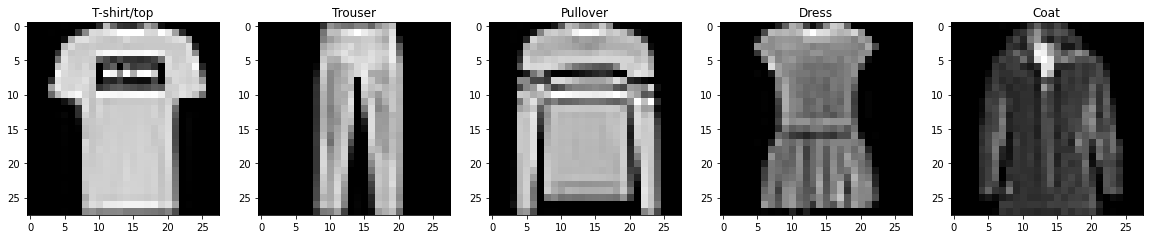

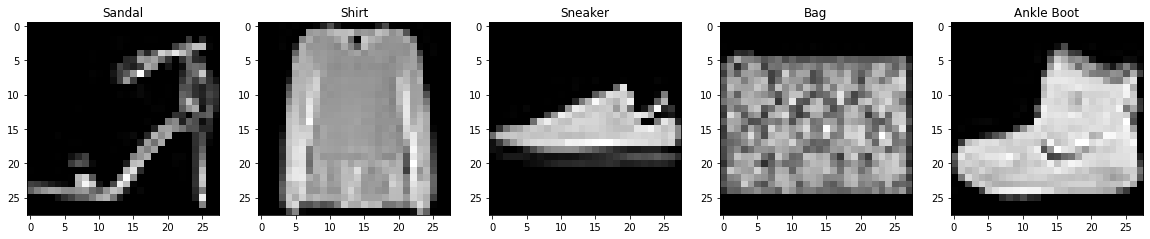

In [4]:
for idx, class_ in enumerate(train_class):
    img_idx = np.where(y_train == class_)[0][0]
    image = x_train[img_idx]
    
    if idx%5 == 0:
        plt.figure(figsize=(20,5))
    plt.subplot(1, 5, idx%5+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_name[class_])

## CNN Model

In [5]:

###############################################################################
#                                ResNet                                       #
###############################################################################


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


In [6]:
def run_model(net, loader, criterion, optimizer, train = True):
    running_loss = 0
    running_accuracy = 0
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    net.to(device)
    # Set mode
    if train:
        net.train()
    else:
        net.eval()


    for i, (X, y) in enumerate(loader):
        # Pass to gpu or cpu
        y = y.type(torch.LongTensor)
        X, y = X.to(device, dtype=torch.float), y.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = net(X)
            _, pred = torch.max(output, 1)
            loss = criterion(output, y)

        # If on train backpropagate
        if train:
            loss.backward()
            optimizer.step()

        # Calculate stats
        running_loss += loss.item()
        running_accuracy += torch.sum(pred == y.detach())
    return running_loss / len(loader), running_accuracy.double() / len(loader.dataset)

In [7]:
class Dataset():
    def __init__(self, images, labels):
        self.transforms = data_transforms
        # load all image files
        self.images = images
        self.labels = labels
        
    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx])
#         y = np.zeros((10))
#         y[label] = 1
        image = self.transforms(image.astype(np.float))
#         print(image.shape,label)
        return image, label

    def __len__(self):
        return len(self.images)

## Training

In [8]:
# Define transforms.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

net = resnet18()
# Train Dataset loader for pytorch model
train_dataset = Dataset(x_train, y_train)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)

test_dataset = Dataset(x_test, y_test)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer
optimizer = optim.Adam(net.parameters())
num_epochs = 50
patience = 3
best_loss = 1e4
def save_model(model_state, filename):
    """ Save model """
    # TODO: add it as checkpoint
    torch.save(model_state,filename)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for e in range(num_epochs):
    start = time.time()
    train_loss, train_acc = run_model(net, train_data_loader,
                                  criterion, optimizer)
    val_loss, val_acc = run_model(net, test_data_loader,
                                  criterion, optimizer, False)
    end = time.time()

    # print stats
    stats = """Epoch: {}\t train loss: {:.3f}, train acc: {:.3f}\t
            val loss: {:.3f}, val acc: {:.3f}\t
            time: {:.1f}s""".format(e+1, train_loss, train_acc, val_loss,
                                    val_acc, end - start)
    print(stats)
    if val_loss < best_loss:
        best_loss = val_loss
        patience = patience
        save_model({
            'arch': 'Resnet-18',
            'state_dict': net.state_dict()
        }, '{}-epoch-{}.pth'.format('Resnet-18', e))
    else:
        patience -= 1
        if patience == 0:
            print('Run out of patience!')
            break



Epoch: 1	 train loss: 0.464, train acc: 0.832	
            val loss: 0.299, val acc: 0.894	
            time: 313.2s
Epoch: 2	 train loss: 0.265, train acc: 0.904	
            val loss: 0.241, val acc: 0.915	
            time: 306.7s
Epoch: 3	 train loss: 0.202, train acc: 0.927	
            val loss: 0.229, val acc: 0.921	
            time: 309.7s
Epoch: 4	 train loss: 0.155, train acc: 0.945	
            val loss: 0.240, val acc: 0.922	
            time: 306.4s
Epoch: 5	 train loss: 0.112, train acc: 0.959	
            val loss: 0.277, val acc: 0.923	
            time: 305.1s
Epoch: 6	 train loss: 0.079, train acc: 0.972	
            val loss: 0.331, val acc: 0.916	
            time: 305.3s
Run out of patience!
